# Fitting the Barnes Gyro relation using a latent fit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import warnings
import matplotlib.gridspec as gridspec
import mystyle as ms
import pandas as pd

warnings.filterwarnings('ignore')

We'll add the uncertainty with a latent implementation.

$P = \tau^a \times b(B - V - c)^d$

where $P$ is rotation in days
$\tau$ is age (in Myr),
B-V are colour in magnitude,
the rest are free parameters


In [2]:
angus = [0.55, 0.40, 0.45, 0.31]

def gyro(tau, bv, a, b, c, d):
    return (tau*1000)**a * b*(bv/1.35 - c)**d

In [8]:
ati = pd.read_csv('../data/atium.csv',index_col=0)
ati = ati[np.isfinite(ati.P.values)]   #Exclude stars without results
ati = ati[ati.chainflag < 1]            #Exclude stars without well constrained results
ati = ati[ati.KIC != 7680114]          #Exclude star that is clearly unevolved
ati = ati[np.isfinite(ati.ebprp.values)] #Exclude star with nan bprp
print('We have {} stars'.format(len(ati)))

We have 48 stars


In [6]:
period_obs = ati.P.values
sigma_p = (ati.l_P.values + ati.u_P.values)/2

age_obs = ati.age.values
sigma_age = (ati.loage.values + ati.upage.values)/2

bprp_obs = ati.bprp.values
sigma_bprp = ati.ebprp.values

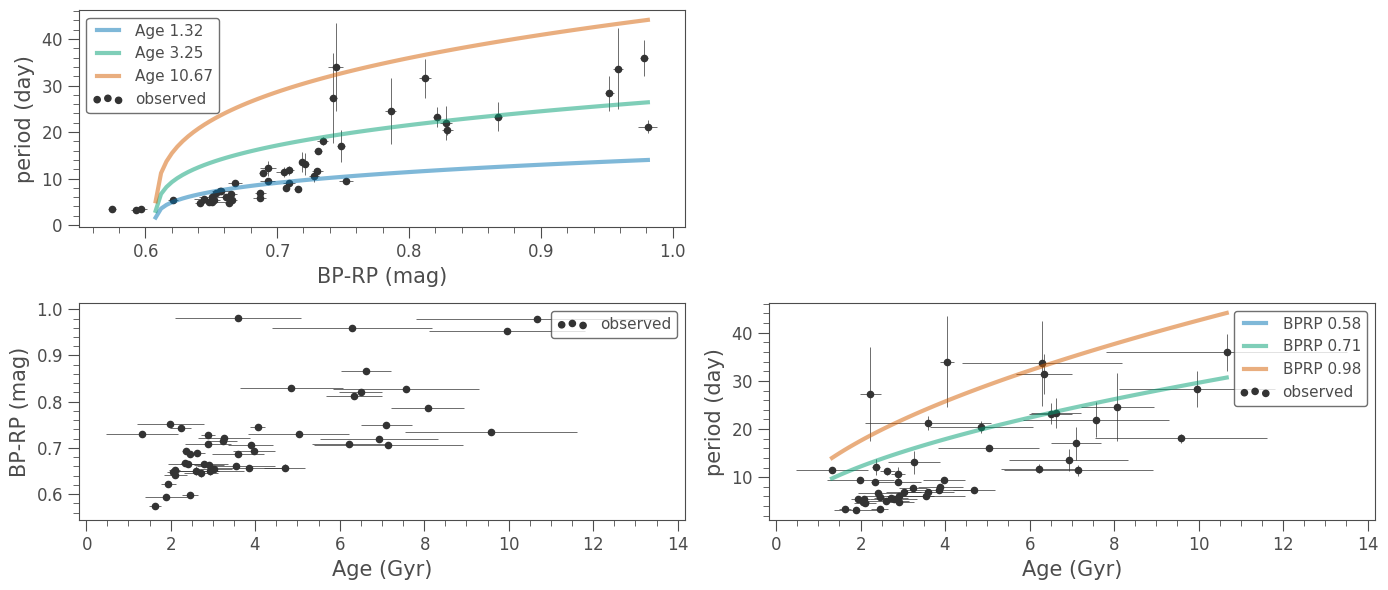

In [7]:
with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
    ax0.scatter(bprp_obs, period_obs,zorder=1, s=20, label='observed')
    ax0.errorbar(bprp_obs, period_obs, yerr=sigma_p, xerr=sigma_bprp, fmt='|',zorder=0)
    ax0.set_xlabel('BP-RP (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
    ax1.scatter(age_obs, period_obs,zorder=1, s=20, label='observed')
    ax1.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
    ax2.scatter(age_obs, bprp_obs,zorder=1, s=20, label='observed')
    ax2.errorbar(age_obs, bprp_obs, yerr=sigma_bprp, xerr=sigma_age, fmt='|',zorder=0)
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('BP-RP (mag)')
    ax2.legend()    
    
    agex = np.linspace(age_obs.min(), age_obs.max(), 100)
    ax1.plot(agex, gyro(agex, bprp_obs.min(), *angus), label='BPRP {:.2f}'.format(bprp_obs.min()), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, np.mean(bprp_obs), *angus), label='BPRP {:.2f}'.format(np.median(bprp_obs)), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, bprp_obs.max(), *angus), label='BPRP {:.2f}'.format(bprp_obs.max()), 
             lw=3, alpha=.5)    
    ax1.legend()
    
    bprpx = np.linspace(bprp_obs.min(), bprp_obs.max(), 100)
    ax0.plot(bprpx, gyro(age_obs.min(), bprpx, *angus), label='Age {:.2f}'.format(age_obs.min()), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(np.mean(age_obs), bprpx, *angus), label='Age {:.2f}'.format(np.median(age_obs)), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(age_obs.max(), bprpx, *angus), label='Age {:.2f}'.format(age_obs.max()), 
             lw=3, alpha=.5)    
    ax0.legend()    
    
    fig.tight_layout()
    plt.show()

Now lets fit for Period using a latent parameter model

In [9]:
latentfit = '''
data {
    int<lower=1> N;
    real<lower=0> P[N];
    real<lower=0> sigma_p[N];
    
    real bprp[N];
    real<lower=0> sigma_bprp[N];
    
    real<lower=0> age[N];
    real<lower=0> sigma_age[N];
}
parameters {
    real<lower=0> a;
    real<lower=0> b;
    real<lower=0> c;
    real<lower=0> d;
    
    real raw_bprp[N];
    real raw_age[N];
}
transformed parameters {
    real<lower=0> true_age[N];
    real true_bprp[N];
    
    for (n in 1:N){
        true_age[n] = sigma_age[n] * raw_age[n] + age[n];
        true_bprp[n] = sigma_bprp[n] * raw_bprp[n] + bprp[n];
    }
}
model {
    real mod[N];
    
    for (n in 1:N){
        mod[n] = (true_age[n]*1000)^a * b * (true_bprp[n] - c)^d;
    }
    
    a ~ normal(0., 1.);
    b ~ normal(0., 1.);
    c ~ normal(0., 1.);
    d ~ normal(0., 1.);
    
    raw_bprp ~ std_normal(); // implies true_bprp ~ normal(bprp, sigma_bprp)
    raw_age ~ std_normal(); // implies true_age ~ normal(age, sigma_age)
    
    mod ~ normal(P, sigma_p);
}
'''
sm = pystan.StanModel(model_code = latentfit, model_name='latentfit')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL latentfit_e82fb0a5d6c6e6a9acc1acbe19b60544 NOW.


In [11]:
data = {'N' : len(period_obs),
       'P' : period_obs,
       'sigma_p' : sigma_p,
       'bprp' : bprp_obs,
       'sigma_bprp' : sigma_bprp,
       'age' : age_obs,
       'sigma_age' : sigma_age}

init = {'a' : angus[0],
        'b' : angus[1],
        'c' : angus[2],
        'd' : angus[3],
        'true_age' : age_obs,
        'true_bprp' : bprp_obs}

In [12]:
fit = sm.sampling(data=data, iter=20000, chains=4, seed=11,
                  init = [init for n in range(4)])

In [13]:
print(fit)

Inference for Stan model: latentfit_e82fb0a5d6c6e6a9acc1acbe19b60544.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a               0.54  5.1e-4   0.05   0.45   0.51   0.54   0.57   0.65  10000    1.0
b               0.62  2.9e-3   0.31   0.18    0.4   0.57   0.79   1.37  11075    1.0
c               0.31  7.6e-4   0.08   0.11   0.26   0.32   0.37   0.44  12263    1.0
d               1.75  3.7e-3   0.41   1.08   1.46   1.71    2.0   2.67  12030    1.0
raw_bprp[1]     0.05  4.2e-3   0.97  -1.83  -0.61   0.06   0.71   1.96  52923    1.0
raw_bprp[2]     1.09  5.3e-3    1.0  -0.88   0.42    1.1   1.78   3.04  36021    1.0
raw_bprp[3]     0.03  4.3e-3   1.01  -1.95  -0.65   0.02   0.71    2.0  53858    1.0
raw_bprp[4]    -0.04  4.2e-3   0.95  -1.89  -0.68  -0.05   0.61   1.81  51251    1.0
raw_bprp[5]     0.71  4.3e-3   0.99  -1.24 

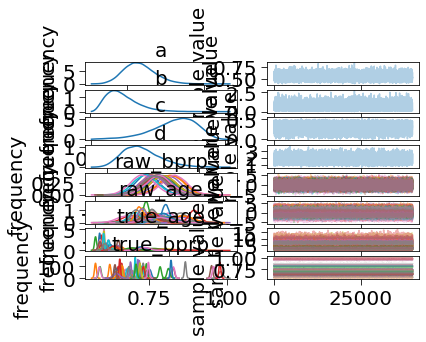

In [14]:
fit.plot()
plt.show()

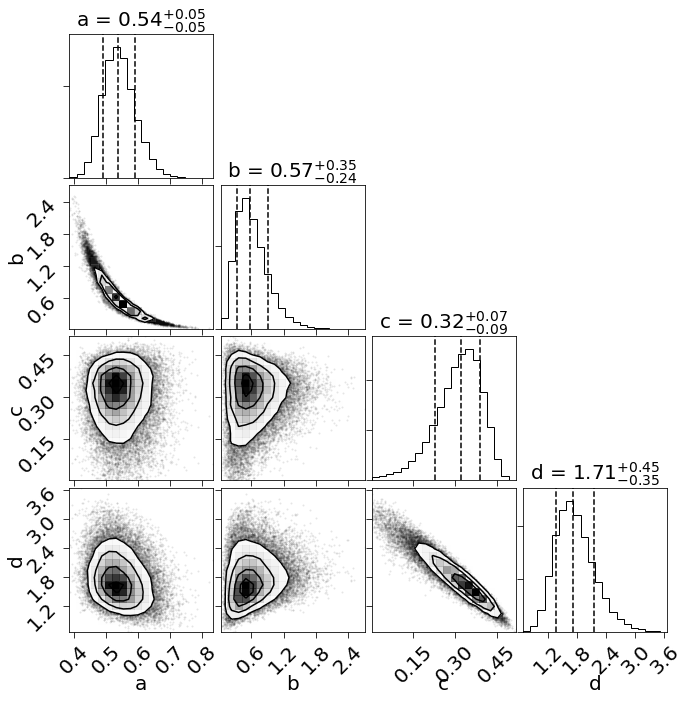

In [17]:
import corner
labels=['a','b','c','d']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, 
              quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

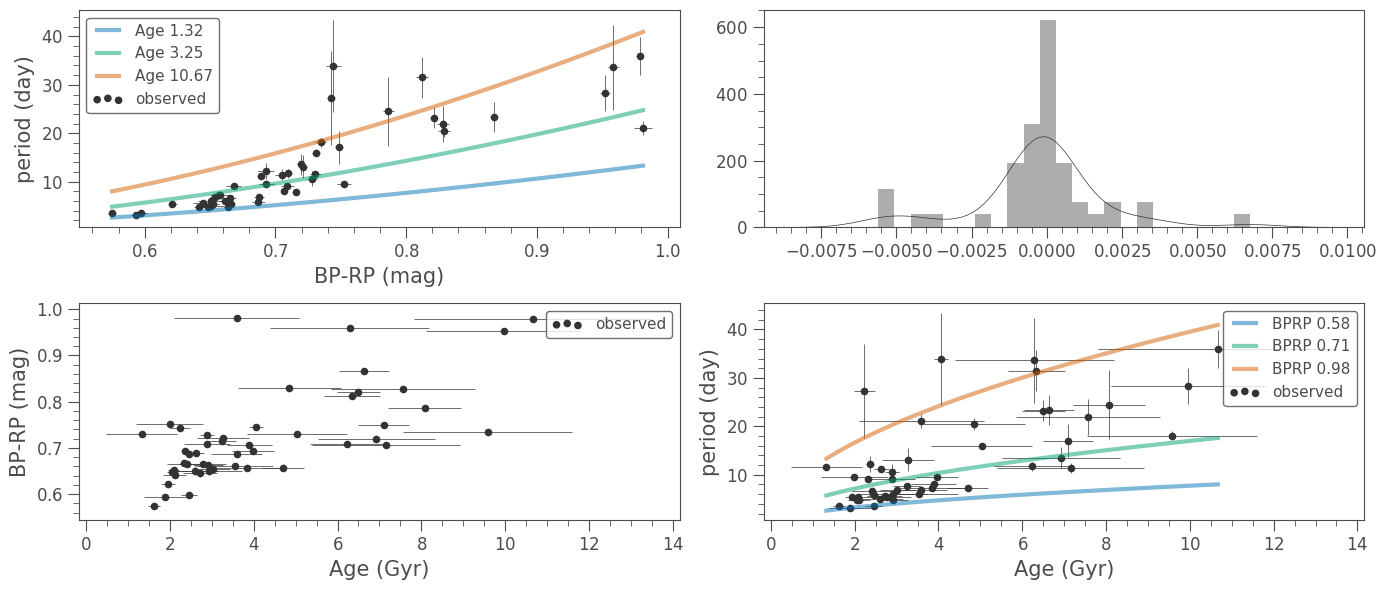

In [27]:
import matplotlib.gridspec as gridspec
import mystyle as ms
import seaborn as sns

def gyro(tau, bprp, a, b, c, d):
    return (tau*1000)**a * b*(bprp - c)**d

gyrores = [np.median(fit[label]) for label in ['a','b','c','d']]

with plt.style.context(ms.ms):
    fig = plt.figure(figsize=(14,6))
    gs = gridspec.GridSpec(2, 2)
    ax0 = plt.subplot(gs[0,:1])
    ax0.scatter(bprp_obs, period_obs,zorder=1, s=20, label='observed')
    ax0.errorbar(bprp_obs, period_obs, yerr=sigma_p, xerr=sigma_bprp, fmt='|',zorder=0)
    ax0.set_xlabel('BP-RP (mag)')
    ax0.set_ylabel('period (day)')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1,1])
    ax1.scatter(age_obs, period_obs,zorder=1, s=20, label='observed')
    ax1.errorbar(age_obs, period_obs, yerr=sigma_p, xerr=sigma_age, fmt='|',zorder=0)
    ax1.set_xlabel('Age (Gyr)')
    ax1.set_ylabel('period (day)')
    ax1.legend()    
    
    ax2 = plt.subplot(gs[1,0])
    ax2.scatter(age_obs, bprp_obs,zorder=1, s=20, label='observed')
    ax2.errorbar(age_obs, bprp_obs, yerr=sigma_bprp, xerr=sigma_age, fmt='|',zorder=0)
    ax2.set_xlabel('Age (Gyr)')
    ax2.set_ylabel('BP-RP (mag)')
    ax2.legend()    
    
    ax3 = plt.subplot(gs[0,1])
    sns.distplot(np.median(fit['true_age'],axis=0) - age_obs, ax=ax3, label='Age')
    sns.distplot((np.median(fit['true_bprp'],axis=0) - bprp_obs)/bprp_obs, ax=ax3, label='BPRP')
#     sns.distplot(gyro(np.median(fit['true_age'],axis=0), np.median(fit['true_bprp'],axis=0),
#                      *gyrores) - age_obs, ax=ax3, label='Period')

#     ax3.scatter(np.median(fit['true_age'],axis=0), np.median(fit['true_bprp'],axis=0),
#                 zorder=1, s=20, label='observed')
#     ax3.errorbar(np.median(fit['true_age'],axis=0), np.median(fit['true_bprp'],axis=0),
#          yerr=np.std(fit['true_bprp'],axis=0), xerr=np.std(fit['true_age'],axis=0), fmt='|',zorder=0)
#     ax3.set_xlabel('Latent Age (Gyr)')
#     ax3.set_ylabel('Latent BP-RP (mag)')
#     ax3.legend()    
    
    
    agex = np.linspace(age_obs.min(), age_obs.max(), 100)
    ax1.plot(agex, gyro(agex, bprp_obs.min(), *gyrores), label='BPRP {:.2f}'.format(bprp_obs.min()), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, np.mean(bprp_obs), *gyrores), label='BPRP {:.2f}'.format(np.median(bprp_obs)), 
             lw=3, alpha=.5)
    ax1.plot(agex, gyro(agex, bprp_obs.max(), *gyrores), label='BPRP {:.2f}'.format(bprp_obs.max()), 
             lw=3, alpha=.5)    
    ax1.legend()
    
    bprpx = np.linspace(bprp_obs.min(), bprp_obs.max(), 100)
    ax0.plot(bprpx, gyro(age_obs.min(), bprpx, *gyrores), label='Age {:.2f}'.format(age_obs.min()), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(np.mean(age_obs), bprpx, *gyrores), label='Age {:.2f}'.format(np.median(age_obs)), 
             lw=3, alpha=.5)
    ax0.plot(bprpx, gyro(age_obs.max(), bprpx, *gyrores), label='Age {:.2f}'.format(age_obs.max()), 
             lw=3, alpha=.5)    
    ax0.legend()    
    
    fig.tight_layout()
    plt.show()

This looks like a tidy fit good enough for a poster!